In [1]:
from mxlpy import Simulator, make_protocol, plot, mca, scan, Model
from mxlpy.types import (
    IntegratorType,
    Result,
)
from scipy.signal import find_peaks, peak_prominences
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from cycler import cycler
import pandas as pd
import mxlbricks.names as n
from typing import Literal

from pathlib import Path

here = Path(__vsc_ipynb_file__).parent

In [2]:
%%capture

cd ..

Both models have differing names for variables, fluxes, and parameters. Therefore you can find a pointer in the following code cell with a pointer.

In [3]:
from model import Saadat2021 as get_saadat2021
# from mxlbricks import get_saadat2021

In [4]:
def set_str_names(which: Literal["this", "mxlbricks"] = "this"):
    
    pointer = {
        "kf_v_Cyc": n.kf(n.cyclic_electron_flow()),
        "Fluo": n.fluorescence(),
        "PPFD": n.pfd(),
        "v_PSI": n.ps1(),
        "v_PSII": n.ps2(),
        "v_Cyc": n.cyclic_electron_flow(),
        "v_Mehler": n.mehler(),
        "v_PQ": n.ptox(),
        "ATP/tot": "ATP/tot",
        "NADPH/tot": "NADPH/tot",
        "Fd_ox/tot": "Fd_ox/tot",
        "PQ_ox/tot": "PQ_ox/tot",
        "PC_ox/tot": "PC_ox/tot",
        "H2O2": n.h2o2(),
        "v_RuBisCO_c": n.rubisco_carboxylase(),
        "PSII_total": "PSII_total",
        "PSI_total": "PSI_total",
        "kcat_v_b6f": n.kcat(n.b6f()),
        "kMehler": "kMehler",
        "kcat_v_RuBisCO_c": n.kcat(n.rubisco_carboxylase()),
        "kcat_v_FBPase": n.kcat(n.fbpase()),
        "kcat_v_SBPase": n.kcat(n.sbpase()),
        "kcat_v_MDAreduct": n.kcat(n.mda_reductase2()),
        "kcat_v_DHAR": n.kcat(n.dehydroascorbate_reductase()),
        "PQH_2": n.pq_red(),
        "Fd_red": n.fd_red(),
        "PC_red": n.pc_red(),
        "NADPH_st": n.nadph(),
        "ATP_st": n.atp(),
        "RUBP": n.rubp(),
        "PGA": n.pga(),
        "FBP": n.fbp(),
        "SBP": n.sbp(),
        "v_b6f": n.b6f(),
        "v_FBPase": n.fbpase(),
        "v_SBPase": n.sbpase(),
        "v_MDAreduct": n.mda_reductase2(),
        "v_DHAR": n.dehydroascorbate_reductase()
    }
    
    if which == "this":
        from model import Saadat2021 as get_saadat2021
        return tuple(pointer.keys())
    else:
        from mxlbricks import get_saadat2021
        return tuple(pointer.values())
    
k_Cyc, Fluo, PPFD, PSI, PSII, CEF, Mehler, PTOX, rel_ATP, rel_NADPH, rel_Fd, rel_PQ, rel_PC, H2O2, rubisco, PSII_tot, PSI_tot, k_b6f, k_Mehler, k_rubisco, k_fbpase, k_sbpase, k_mdareduct, k_dhar, PQH2, Fdred, PCred, NADPH, ATP, RUBP, PGA, FBP, SBP, vb6f, vFBPase, vSBPase, vMDAreduct, vDHAR = set_str_names()

In [5]:
def pam(
    s: Simulator,
    t_relax: float, #Duration of relaxtion
    t_pulse: float, #Duration of Pulse
    numpeaks_phase0: float,
    numpeaks_phase1: float,
    pfd_dark: float,
    pfd_illumination: float,
    pfd_pulse: float,
    max_duration: float = 2500,
    pfd_str: str = "PPFD"
):
    step_duration = t_relax + t_pulse
    max_steps = int(max_duration // step_duration) + 1
    
    pfds = list(
        [pfd_dark, pfd_pulse] * numpeaks_phase0 + [pfd_illumination, pfd_pulse] * numpeaks_phase1 + [pfd_dark, pfd_pulse] * (max_steps - (numpeaks_phase0 + numpeaks_phase1))
        
    )
    time_points = list(it.chain.from_iterable((t_relax, t_pulse) for i in range(max_steps)))
    
    ptrc = [
        (t_end, {pfd_str: pfd}) for t_end, pfd in zip(time_points, pfds)
    ]
    
    pam_ptrc = make_protocol(ptrc)
    
    s.simulate_protocol(pam_ptrc)
    
    return s, pam_ptrc

def npq(
    s: Simulator,
    prominence: float,
    fluo_str: str = "Fluo"
):
    
    res = s.get_result().get_variables()
    
    fluo_results = res[fluo_str] / max(res[fluo_str])
    
    # Find the Flourescence peaks (Fmaxs)
    peaks, _ = find_peaks(fluo_results, height=0, prominence=prominence)
    
    # Get time at peaks
    time = res.iloc[peaks].index
    
    # Calculate Fm
    Fm = fluo_results.iloc[peaks].values
    
    #Calculate NPQ
    NPQ = (Fm[0] - Fm) / Fm
    
    # Find the minima around the peaks
    prominences, prominences_left, prominences_right = peak_prominences(
                (fluo_results), peaks
            )  
    
    # Fo is always the minima before the peak
    Fo = res[fluo_str].iloc[prominences_left].values
    
    return time, Fm, NPQ, Fo

## Figure 2

In [6]:
t_relax=120
t_pulse=0.8
numpeaks_phase0=2
numpeaks_phase1=10
pfd_dark=50
pfd_illumination=1000
pfd_pulse=5000

sim_fig2 = Simulator(get_saadat2021())
sim_fig2.update_parameter(k_Cyc, 0)

sim_fig2, pam_ptrc_fig2 = pam(
    sim_fig2,
    t_relax=t_relax,
    t_pulse=t_pulse,
    numpeaks_phase0=numpeaks_phase0,
    numpeaks_phase1=numpeaks_phase1,
    pfd_dark=pfd_dark,
    pfd_illumination=pfd_illumination,
    pfd_pulse=pfd_pulse,
    pfd_str=PPFD
)

time_fig2, Fm_fig2, NPQ_fig2, Fo_fig2 = npq(sim_fig2, 0.1)

In [7]:
def create_figure2(
    sim,
    pam_ptrc,
    time,
    NPQ,
    pfd_str: str = "PPFD",
    fluo_str: str = "Fluo",
):
    res = sim.get_result().get_variables()

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(res[fluo_str] / max(res[fluo_str]), color="red", lw=2.5, label="Fluorescence")
    ax.plot(time, NPQ, linestyle="dashed", color="black", label="NPQ", lw=2)

    ax.legend(loc="upper right")

    pam_ptrc_cleaned = pam_ptrc[pam_ptrc[pfd_str] != pfd_pulse]

    plot.shade_protocol(
        pam_ptrc_cleaned[pfd_str],
        ax=ax,
        vmin=pfd_dark,
        vmax=pfd_illumination,
        add_legend=False,
        alpha=0.3
    )

    ax.set(
        ylim=(0, 1.1),
        xlim=(0, 2500),
        xlabel="Time/(s)",
        ylabel="Fluorescence (normalised)",
    )
    
    return fig, ax

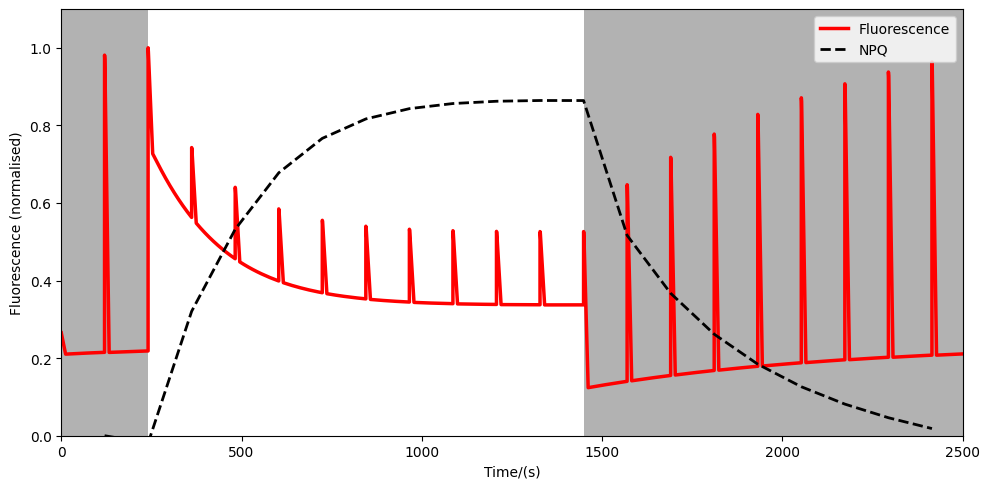

In [8]:
create_figure2(
    sim=sim_fig2,
    pam_ptrc=pam_ptrc_fig2,
    time=time_fig2,
    NPQ=NPQ_fig2,
    pfd_str=PPFD,
    fluo_str=Fluo
)

plt.tight_layout()

plt.savefig(here / "Saadat2021_fig2.svg", dpi=300)

plt.show()

## Figure 3

In [9]:
variables, fluxes = scan.steady_state(
    get_saadat2021(),
    to_scan=pd.DataFrame({PPFD: np.linspace(50, 1500, 200)})
)

fig3_res = pd.concat([variables, fluxes], axis=1)

100%|██████████| 200/200 [00:15<00:00, 12.72it/s]


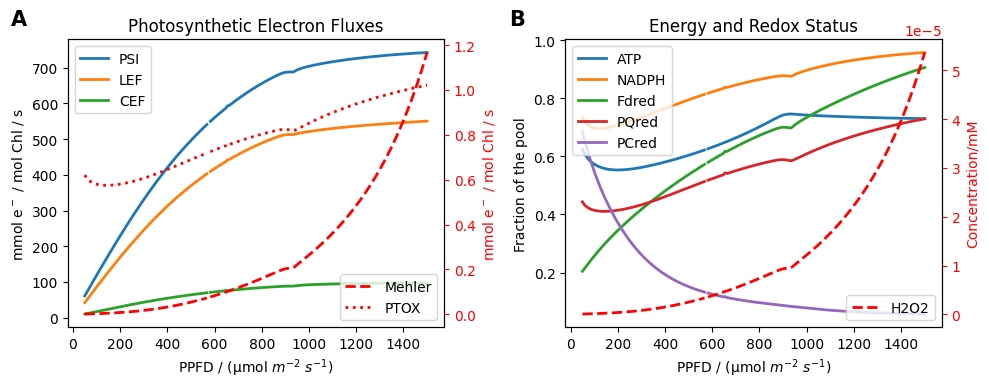

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
filtered_colors = [c for c in default_colors if c.lower() != '#d62728']
plt.rcParams['axes.prop_cycle'] = cycler(color=filtered_colors)

for ax in axs:
    ax.set_xlabel(r"PPFD / (µmol $m^{-2}\ s^{-1})$")

# FIGURE A

axs[0].set_title("Photosynthetic Electron Fluxes")
axs[0].text(-0.15, 1.05, "A", transform=axs[0].transAxes, size=15, weight="bold")
secax = axs[0].twinx()

left_plots = {
    "PSI": fig3_res[PSI],
    "LEF": fig3_res[PSII] * 2,
    "CEF": fig3_res[CEF],
    "Mehler": fig3_res[Mehler],
    "PTOX": fig3_res[PTOX]
}

for label, vals in left_plots.items():
    if label in ["Mehler", "PTOX"]:
        ax = secax
        color = "red"
        if label == "Mehler":
            ls = "dashed"
        else:
            ls = "dotted"
    else:
        ax = axs[0]
        color=None
        ls="solid"
    
    ax.plot(vals, label=label, lw=2, color=color, ls=ls)

axs[0].set_ylabel("mmol e$^-$ / mol Chl / s")
axs[0].legend(loc="upper left")
    
secax.set_ylabel("mmol e$^-$ / mol Chl / s", color="red")
secax.tick_params(axis="y", colors="red")
secax.legend(loc="lower right")

# FIGURE B

axs[1].set_title("Energy and Redox Status")
axs[1].text(-0.15, 1.05, "B", transform=axs[1].transAxes, size=15, weight="bold")
secax = axs[1].twinx()

m = get_saadat2021()

right_plots = {
    "ATP": fig3_res[rel_ATP],
    "NADPH": fig3_res[rel_NADPH],
    "Fdred": fig3_res[rel_Fd],
    "PQred": fig3_res[rel_PQ],
    "PCred": fig3_res[rel_PC],
    "H2O2": fig3_res[H2O2]
}

for label, vals in right_plots.items():
    if label == "H2O2":
        ax = secax
        color = "red"
        ls = "dashed"
    else:
        ax = axs[1]
        color=None
        ls="solid"
        
    ax.plot(vals, label=label, color=color, ls=ls, lw=2)

axs[1].set_ylabel("Fraction of the pool")
axs[1].legend(loc="upper left")
secax.set_ylabel("Concentration/mM", color="red")
secax.tick_params(axis="y", colors="red")
secax.legend(loc="lower right")

plt.tight_layout()

plt.savefig(here / "Saadat2021_fig3.svg", dpi=300)

plt.show()

## Figure 4

In [11]:
# Steady State Worker to maximum of 10k timepoints, for quicker simulation with assumption
def _steady_state_until_10k(
    model: Model,
    *,
    rel_norm: bool,
    integrator: IntegratorType | None,
    y0: dict[str, float] | None,
) -> Result:
    tolerance: float = 1e-6
    try:
        res = (
            Simulator(model, integrator=integrator, y0=y0).simulate(10_000).get_result()
        )
    except ZeroDivisionError:
        res = None
    if res is not None:
        y = res.raw_variables[-1]
        diff = (
            (y.iloc[-1] - y.iloc[-2]) / y.iloc[-1]
            if rel_norm
            else y.iloc[-1] - y.iloc[-2]
        )
        if np.linalg.norm(diff, ord=2) < tolerance:
            return res
    return Result.default(model=model, time_points=np.array([0.0]))

In [12]:
m = get_saadat2021()

m.update_parameter(PPFD, 1000)

variables, fluxes = scan.steady_state(
    m,
    to_scan=pd.DataFrame({k_Cyc: get_saadat2021().get_parameter_values()[k_Cyc] * (2 ** np.linspace(-3, 3))}),
    worker=_steady_state_until_10k
)

fig4_res = pd.concat([variables, fluxes], axis=1)

100%|██████████| 50/50 [01:34<00:00,  1.90s/it]


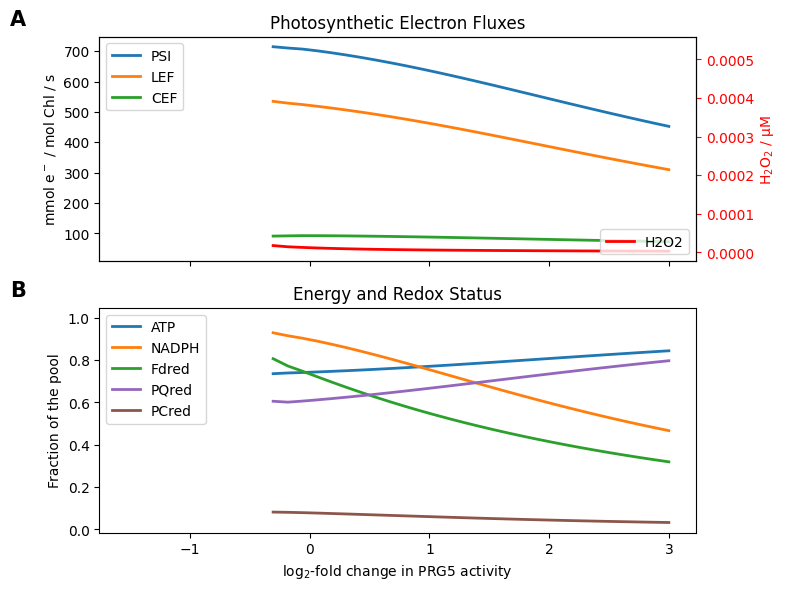

In [13]:
fig, axs = plt.subplots(nrows=2, figsize=(8, 6), sharex=True)
xvals = np.log2(fig4_res.index / get_saadat2021().get_parameter_values()[k_Cyc])

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
filtered_colors = [c for c in default_colors if c.lower() != '#d62728']
plt.rcParams['axes.prop_cycle'] = cycler(color=filtered_colors)

# FIGURE A

axs[0].set_title("Photosynthetic Electron Fluxes")
axs[0].text(-0.15, 1.05, "A", transform=axs[0].transAxes, size=15, weight="bold")

secax = axs[0].twinx()

secax.set_ylabel("H$_2$O$_2$ / µM", color="red")
secax.tick_params(axis="y", colors="red")

left_plots = {
    "PSI": fig4_res[PSI],
    "LEF": fig4_res[PSII] * 2,
    "CEF": fig4_res[CEF],
    "H2O2": fig4_res[H2O2]
}

for label, vals in left_plots.items():
    if label == "H2O2":
        ax = secax
        color = "red"
    else:
        ax = axs[0]
        color=None
    
    ax.plot(xvals, vals.values, label=label, lw=2, color=color)
    
axs[0].set_ylabel("mmol e$^-$ / mol Chl / s")
axs[0].legend(loc="upper left")
secax.legend(loc="lower right")
    
# FIGURE B

axs[1].set_title("Energy and Redox Status")
axs[1].text(-0.15, 1.05, "B", transform=axs[1].transAxes, size=15, weight="bold")

m = get_saadat2021()

right_plots = {
    "ATP": fig4_res[rel_ATP],
    "NADPH": fig4_res[rel_NADPH],
    "Fdred": fig4_res[rel_Fd],
    "PQred": fig4_res[rel_PQ],
    "PCred": fig4_res[rel_PC],
}

for label, vals in right_plots.items():
    axs[1].plot(xvals, vals.values, label=label, lw=2)
    
axs[1].set_xlabel("log$_2$-fold change in PRG5 activity")
axs[1].set_ylabel("Fraction of the pool")
axs[1].legend(loc="upper left")

plt.tight_layout()

plt.savefig(here / "Saadat2021_fig4.svg", dpi=300)

plt.show()

# Figure 5

In [14]:
ptrc = make_protocol([(60, {PPFD: 600}), (60, {PPFD: 40})] * 5)

s = Simulator(get_saadat2021())
s.simulate_protocol(ptrc, time_points_per_step=50)
fig5_variables_wt, fig5_fluxes_wt = s.get_result()

s = Simulator(get_saadat2021())
s.update_parameter(k_Cyc, 0)
s.simulate_protocol(ptrc, time_points_per_step=20)
fig5_variables_ko, fig5_fluxes_ko = s.get_result()

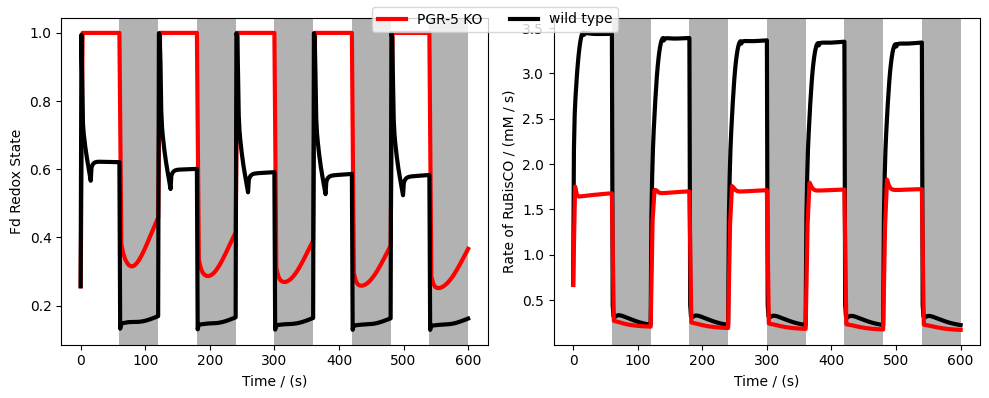

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

m = get_saadat2021()

lw = 3

axs[0].plot(fig5_variables_ko[rel_Fd], label = "PGR-5 KO", lw=lw, color="red")
axs[0].plot(fig5_variables_wt[rel_Fd], label = "wild type", lw=lw, color="black")

axs[1].plot(fig5_fluxes_wt[rubisco], lw=lw, color="black")
axs[1].plot(fig5_fluxes_ko[rubisco], lw=lw, color="red")

for ax in axs:
    plot.shade_protocol(
        ptrc[PPFD],
        ax=ax,
        add_legend=False,
        alpha=0.3
    )
    
    ax.set_xlabel("Time / (s)")
    
axs[0].set_ylabel("Fd Redox State")
axs[1].set_ylabel("Rate of RuBisCO / (mM / s)")

fig.legend(loc="upper center", ncols=2)

plt.tight_layout()

plt.savefig(here / "Saadat2021_fig5.svg", dpi=300)

plt.show()

# Figure 6

In [16]:
scan_params = {
    PSII_tot: "PS2",
    PSI_tot: "PS1",
    k_b6f: "b$_6$f",
    k_Cyc: "PGR5",
    k_Mehler: "Mehler",
    k_rubisco: "RuBisCO",
    k_fbpase: "FBPase",
    k_sbpase: "SBPase",
    k_mdareduct: "MDAR",
    k_dhar: "DHAR"
}

m = get_saadat2021()

m.update_parameter(PPFD, 100)

ppfd100_variables, ppfd100_fluxes = mca.response_coefficients(
    m,
    to_scan=scan_params.keys()
)

m = get_saadat2021()

m.update_parameter(PPFD, 1000)

ppfd1000_variables, ppfd1000_fluxes = mca.response_coefficients(
    m,
    to_scan=scan_params.keys()
)

100%|██████████| 10/10 [00:03<00:00,  3.01it/s]


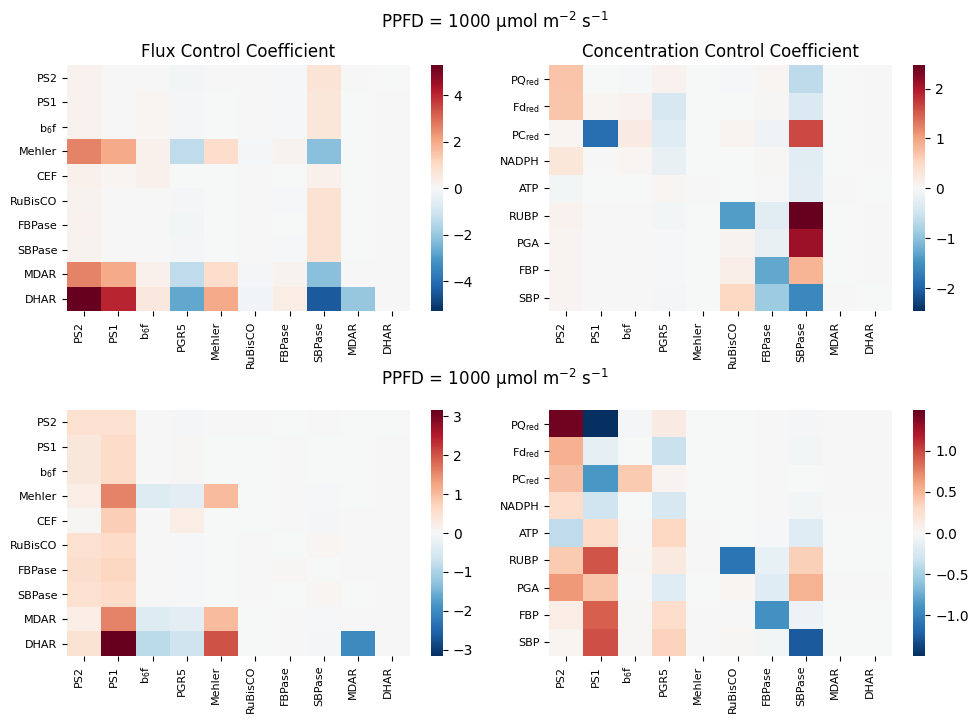

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

for res in [ppfd1000_variables, ppfd100_variables, ppfd1000_fluxes, ppfd100_fluxes]:

    col_lst = res.columns.to_list()

    for i in range(len(col_lst)):
        if col_lst[i] in scan_params.keys():
            col_lst[i] = scan_params[col_lst[i]]
        
    res.columns = col_lst

new_vars_pointer = {
    PQH2: r"PQ$_{\mathrm{red}}$",
    Fdred: r"Fd$_{\mathrm{red}}$",
    PCred: r"PC$_{\mathrm{red}}$",
    NADPH: "NADPH",
    ATP: "ATP",
    RUBP: "RUBP",
    PGA: "PGA",
    FBP: "FBP",
    SBP: "SBP"
}

for var_res in [ppfd1000_variables, ppfd100_variables]:

    index_lst = var_res.index.to_list()

    for i in range(len(index_lst)):
        if index_lst[i] in new_vars_pointer.keys():
            index_lst[i] = new_vars_pointer[index_lst[i]]
        
    var_res.index = index_lst

new_fluxes_pointer = {
    PSII: "PS2",
    PSI: "PS1",
    vb6f: "b$_6$f",
    Mehler: "Mehler",
    CEF: "CEF",
    rubisco: "RuBisCO",
    vFBPase: "FBPase",
    vSBPase: "SBPase",
    vMDAreduct: "MDAR",
    vDHAR: "DHAR"
}

for flux_res in [ppfd1000_fluxes, ppfd100_fluxes]:

    index_lst = flux_res.index.to_list()

    for i in range(len(index_lst)):
        if index_lst[i] in new_fluxes_pointer.keys():
            index_lst[i] = new_fluxes_pointer[index_lst[i]]
        
    flux_res.index = index_lst


plot.heatmap(ppfd1000_variables.loc[new_vars_pointer.values()], ax=axs[0, 1])
plot.heatmap(ppfd100_variables.loc[new_vars_pointer.values()], ax=axs[1, 1])

plot.heatmap(ppfd1000_fluxes.loc[new_fluxes_pointer.values()], ax=axs[0, 0])
plot.heatmap(ppfd100_fluxes.loc[new_fluxes_pointer.values()], ax=axs[1, 0])

for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticklabels(ax.get_yticklabels(), fontdict={"fontsize": 8})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={"fontsize": 8})
    
axs[0,0].set_title("Flux Control Coefficient")
axs[0,1].set_title("Concentration Control Coefficient")

fig.text(0.5, 1, r"PPFD = 1000 $\mathrm{\mu mol\ m^{-2}\ s^{-1}}$", ha="center", fontdict={"fontsize": 12})
fig.text(0.5, 0.49, r"PPFD = 1000 $\mathrm{\mu mol\ m^{-2}\ s^{-1}}$", ha="center", fontdict={"fontsize": 12})

plt.tight_layout(h_pad=3)

plt.savefig(here / "Saadat2021_fig6.svg", dpi=300)

plt.show()

# Figure 7

In [18]:
ppfds = pd.DataFrame({PPFD: np.linspace(50, 1500, 15)})
kcefs = pd.DataFrame({k_Cyc: get_saadat2021().get_parameter_values()[k_Cyc] * (2 ** np.linspace(-3, 3, 15))})

cross = ppfds.merge(kcefs, how="cross")

variables, fluxes = scan.steady_state(
    get_saadat2021(),
    to_scan=cross,
    worker=_steady_state_until_10k
)

100%|██████████| 225/225 [02:48<00:00,  1.34it/s]


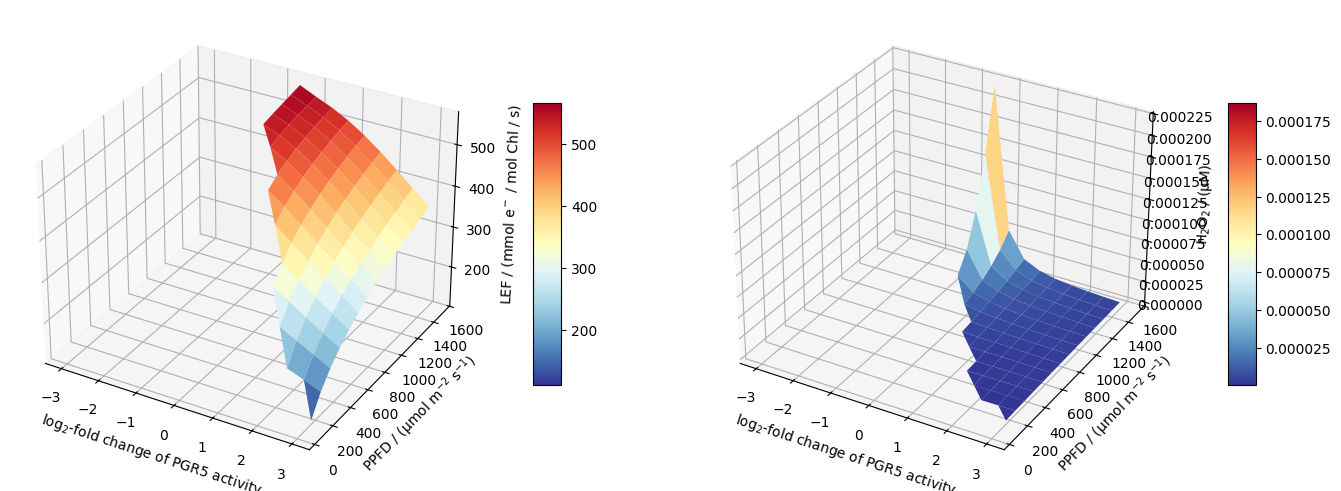

In [19]:
# Unstack to reshape into 2D grid
H2O2_z = variables[H2O2].unstack(level=k_Cyc)
LEF_z = fluxes[PSII].unstack(level=k_Cyc)
X = np.log2(H2O2_z.columns.values)  # y values
Y = H2O2_z.index.values     # x values
X, Y = np.meshgrid(X, Y)
H2O2_z = H2O2_z.values  # z values
LEF_z = LEF_z.values * 2

fig, axs = plt.subplots(ncols=2, subplot_kw=dict(projection='3d'), figsize = (15, 5))

# Surface plot
surf_left = axs[0].plot_surface(X, Y, LEF_z, cmap='RdYlBu_r')
surf_right = axs[1].plot_surface(X, Y, H2O2_z, cmap='RdYlBu_r')

for ax, surf in zip(axs, [surf_left, surf_right]):
    plt.colorbar(surf, ax=ax, shrink=0.6, pad=0.07, aspect=10)
    ax.set_xlabel("log$_2$-fold change of PGR5 activity")
    ax.set_ylabel("PPFD / (µmol m$^{-2}$ s$^{-1}$)")

axs[0].set_zlabel("LEF / (mmol e$^-$ / mol Chl / s)")
axs[1].set_zlabel("H$_2$O$_2$ / (µM)")

plt.tight_layout(w_pad=-1)

plt.savefig(here / "Saadat2021_fig7.svg", dpi=300)

plt.show()